In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, importlib
sys.path.append('../_shared_packages')
import process_cl2_logfile as process_cl2#This underline is unavoidable
from IPython.display import display

use_nominal_cl2 = True

In [3]:
# Import stuff
bypass_data_929 = pd.read_csv("../_exported_data/bypasses_09-29_cl2_campaign_after_mfc_zero.csv")
conversion_data_929 = pd.read_csv("../_exported_data/conversions_09-29_cl2_campaign_after_mfc_zero.csv")
bypass_data_924 = pd.read_csv("../_exported_data/bypasses_09-24_cl2_sweeps_no_cofeed.csv")
conversion_data_924 = pd.read_csv("../_exported_data/conversions_09-24_cl2_sweeps_no_cofeed.csv")
bypass_data_1023 = pd.read_csv("../_exported_data/bypasses_10-23_cl2_misc_follow_ups.csv")
conversion_data_1023 = pd.read_csv("../_exported_data/conversions_10-23_cl2_misc_follow_ups.csv")
all_bypass_data = pd.concat([bypass_data_924,bypass_data_929,bypass_data_1023],axis=0,ignore_index=True).reindex()
all_conversion_data = pd.concat([conversion_data_924,conversion_data_929,conversion_data_1023],axis=0,ignore_index=True).reindex()

<h1> First Attempt at Cl* Count </h1>

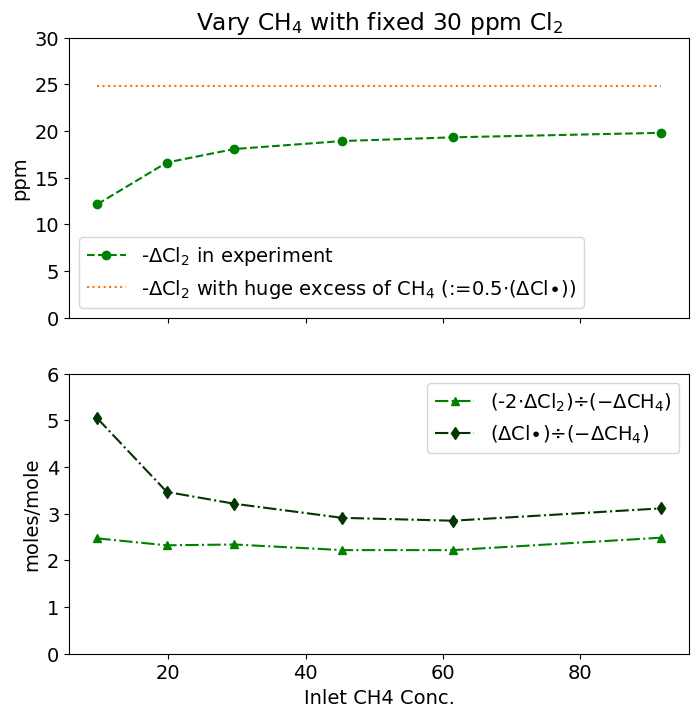

In [4]:
# Whittle it down to the experiments we want
titration_data = all_conversion_data[all_conversion_data["experiment_name"]=='10-10-24 Cl* Count w/ Excess CH4']
prev_exp_data = all_conversion_data[all_conversion_data["experiment_name"]=='09-30-24 Sweep CH4 (10-90 ppm)']

ch4_baselines_exp = prev_exp_data['Selected: CH4 (ppm) baseline']
ch4_conversions_exp = prev_exp_data['Selected: CH4 (ppm) conversion']
exp_start_times = prev_exp_data['start_time']
titration_start_times = titration_data['start_time']

# Calculate the chlorine levels via the recorded conversions
cl2_conversions_exp = [conv*(30.0/baseline) for conv,baseline in zip(prev_exp_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'],prev_exp_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline'])]
cl2_conversions_titration = [conv*(30.0/baseline) for conv,baseline in zip(titration_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'],titration_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline'])]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(ch4_baselines_exp,cl2_conversions_exp,label="-$\Delta$Cl$_2$ in experiment",color='g',marker='o',linestyle='--')
ax1.plot(ch4_baselines_exp,np.ones(len(ch4_baselines_exp))*np.average(cl2_conversions_titration),
         label="-$\Delta$Cl$_2$ with huge excess of CH$_4$ (:=0.5$\cdot$($\Delta$Cl$\\bullet$))",color='xkcd:orange',linestyle=':')
ax1.set_ylabel('ppm')
ax1.set_ylim(0,30)
ax1.legend()

# Make the second plot
ch4_per_cl2 = [2*b/a for a,b in zip(ch4_conversions_exp,cl2_conversions_exp)]
ax2.plot(ch4_baselines_exp,ch4_per_cl2,label="(-2$\cdot\Delta$Cl$_2$)$\div$$(-\Delta$CH$_4)$",color='g',linestyle='-.',marker='^')
cl_star_budget = 2*np.average(cl2_conversions_titration)
ch4_per_cl_star = [cl_star_budget/a for a in ch4_conversions_exp]
ax2.plot(ch4_baselines_exp,ch4_per_cl_star,label="($\Delta$Cl$\\bullet$)$\div$$(-\Delta$CH$_4)$",color='xkcd:dark green',linestyle='-.',marker='d')
ax2.set_ylabel("moles/mole")
ax2.set_xlabel('Inlet CH4 Conc.')
ax2.set_ylim(0,6)
ax2.legend()

ax1.set_title("Vary CH$_4$ with fixed 30 ppm Cl$_2$")
plt.show()

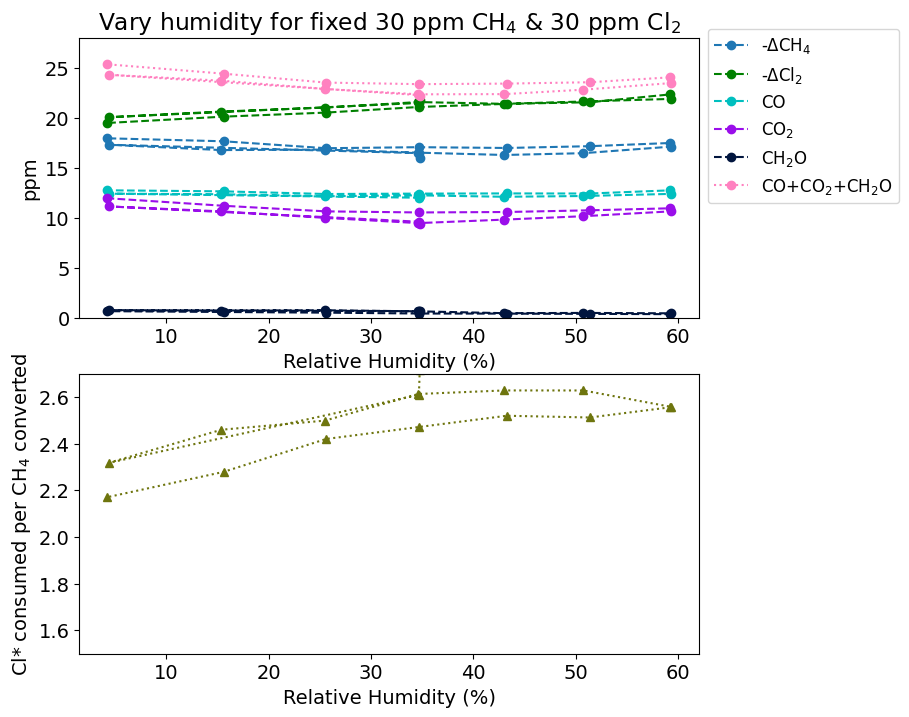

In [5]:
# Whittle it down to the experiments we want
exps=['12-10-24 Humidity Sweep']#,'09-27-24 Humidity Sweep (10-60%)']
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]

ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion']
start_times = conversion_data['start_time']

# Extract the means for each bypass period
means = (bypass_data.groupby('closest_start_time').mean(numeric_only=True).reset_index()) #Quick and dirty; we can use apply to do more involved operations, though.
humidities = [float(means[means.closest_start_time==t]['Humidity Probe: Rel. Humidity (%)']) for t in start_times] #Lookup the correct entry in the groupby
humidities = [v*(1.0/(1-6.0/200.0)) for v in humidities] # Scale appropriately to adjust for added chlorine flow
co2 = [float(means[means.closest_start_time==t]['Picarro: CO2 (ppm)']) for t in start_times]
co = [float(means[means.closest_start_time==t]['FTIR: CO (ppm)']) for t in start_times]
ch2o = [float(means[means.closest_start_time==t]['FTIR: CH2O (ppm)']) for t in start_times]

# Calculate the chlorine conversions in ppm, combining the conversion from the electrochemical sensor with the concentration setpoint from the MFC's
nom_cl2 = [(1000.0/200.0)*float(means[means.closest_start_time==t]['Cl2 MFC: Setpoint Entry']) for t in start_times]
cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'],conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline'])]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2)) = plt.subplots(nrows=2,figsize=(8,8),sharex=True)

# Make the first plot
ax1.plot(humidities,ch4_conversions,label='-$\Delta$CH$_4$',marker='o',linestyle='--')
ax1.plot(humidities,cl2_conversions,label='-$\Delta$Cl$_2$',color='g',marker='o',linestyle='--')
ax1.plot(humidities,co,label='CO',color='c',marker='o',linestyle='--')
ax1.plot(humidities,co2,label='CO$_2$',color='xkcd:violet',marker='o',linestyle='--')
ax1.plot(humidities,ch2o,label='CH$_2$O',color='xkcd:navy',marker='o',linestyle='--')
ax1.plot(humidities,[a+b+c for a,b,c in zip(co,co2,ch2o)],label='CO+CO$_2$+CH$_2$O',color='xkcd:pink',linestyle=':',marker='o')
ax1.set_ylabel("ppm")
ax1.set_xlabel("Relative Humidity (%)")
ax1.set_ylim(0,28)
ax1.legend(fontsize=12,loc='lower left',bbox_to_anchor=(1,0.38))
ax1.xaxis.set_tick_params(labelbottom=True)

# Make the second plot
ch4_per_cl_star = [2*b/a for a,b in zip(ch4_conversions,cl2_conversions)]
ax2.plot(humidities,ch4_per_cl_star,label="CH$_4$ Converted per Cl*",color='xkcd:olive',linestyle=':',marker='^')
ax2.set_ylabel("Cl* consumed per CH$_4$ converted")
ax2.set_xlabel("Relative Humidity (%)")
ax2.xaxis.set_tick_params(labelbottom=True)
ax2.set_ylim(1.5,2.7)

ax1.set_title("Vary humidity for fixed 30 ppm CH$_4$ & 30 ppm Cl$_2$")
plt.show()

/var/folders/19/m383lrvn5w37h21r84kj55q40000gp/T/ipykernel_7474/2928730210.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversion_data['Light Pos'] = [translate_tags(t)['light_pos'] for t in conversion_data['tags']]
/var/folders/19/m383lrvn5w37h21r84kj55q40000gp/T/ipykernel_7474/2928730210.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversion_data['Exp Type'] = [translate_tags(t)['type'] for t in conversion_data['tags']]
/var/folders/19/m383lrvn5w37h21r84kj55q40000gp/T/ipykernel_7474/2928

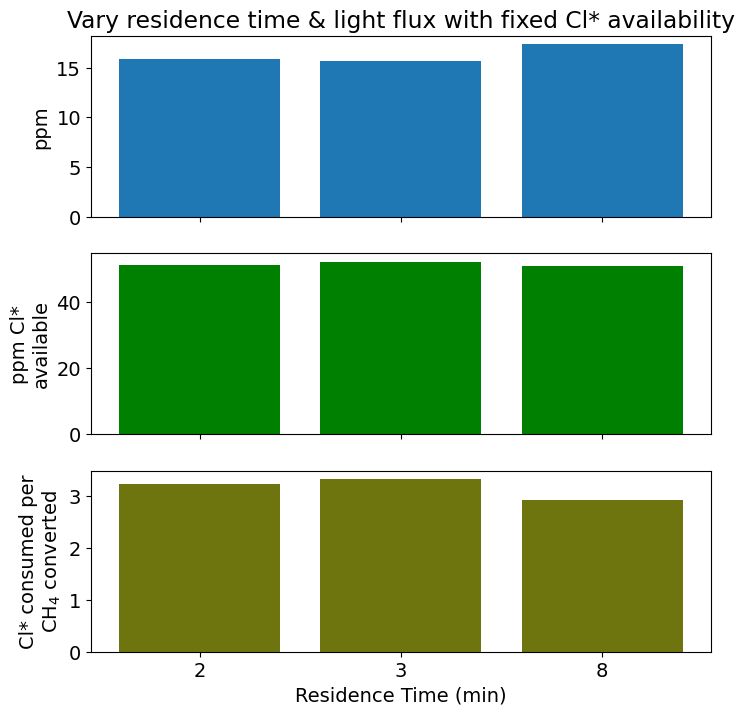

In [25]:
# Whittle it down to the experiments we want
exps=['12-2 Light Distance Log '+str(i) for i in [1,2,3,4]]
bypass_data = all_bypass_data[all_bypass_data["experiment_name"].isin(exps)]
conversion_data = all_conversion_data[all_conversion_data["experiment_name"].isin(exps)]

# Extract tags
def translate_tags(string):
    str_rep = ("dict("+string.replace(";",",")+")")
    return eval(str_rep)
def get_rt(t):
    if t=='11':
        return '3'
    if t=='25':
        return '8'
    if t=='HP':
        return '2'
conversion_data['Light Pos'] = [translate_tags(t)['light_pos'] for t in conversion_data['tags']]
conversion_data['Exp Type'] = [translate_tags(t)['type'] for t in conversion_data['tags']]
conversion_data = conversion_data[conversion_data['Light Pos']!='18']
conversion_data['Res Time'] = [get_rt(t) for t in conversion_data['Light Pos']]
conversion_data = conversion_data.sort_values(by=['Exp Type','Res Time'])

cases = conversion_data['Res Time'][:3]
ch4_conversions = conversion_data['Selected: CH4 (ppm) conversion'][:3]


start_times = conversion_data['start_time']
# Calculate the chlorine conversions in ppm, combining the conversion from the electrochemical sensor with the concentration setpoint from the MFC's
nom_cl2 = [30 for t in start_times]
cl2_conversions = [conv*(nom/baseline) for nom,conv,baseline in zip(nom_cl2,conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) conversion'],conversion_data['Cl2 LabJack: Cl2 reading minus zero (mV) baseline'])]
cl_star_available = [2*i for i in cl2_conversions[3:]]

# Setup subplots
plt.rcParams.update({'font.size': 14})
(fig,(ax1,ax2,ax3)) = plt.subplots(nrows=3,figsize=(8,8),sharex=True)

# Make the first plot
ax1.set_ylabel("ppm")
ax1.bar(cases,ch4_conversions,color='C0')

ax2.bar(cases,cl_star_available,color='g')
ax2.set_ylabel("ppm Cl*\navailable")

# Make the second plot
ch4_per_cl_star = [b/a for a,b in zip(ch4_conversions,cl_star_available)]
ax3.bar(cases,ch4_per_cl_star,color='xkcd:olive')
ax3.set_ylabel("Cl* consumed per\nCH$_4$ converted")
ax3.set_xlabel("Residence Time (min)")
ax3.xaxis.set_tick_params(labelbottom=True)

ax1.set_title("Vary residence time & light flux with fixed Cl* availability")
plt.show()